<a href="https://www.kaggle.com/code/yogisaireddy/skincancerprediction?scriptVersionId=201879290" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [3]:
image_size = (244, 224)
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    r"/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = keras.utils.image_dataset_from_directory(
    r"/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 9605 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [4]:
import numpy as np
num_classes = len(np.unique(train_ds))
print("Number of classes in the dataset:", num_classes)

Number of classes in the dataset: 1


In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    r"/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train",  # Replace with your training data path
    target_size=(224, 224),
    batch_size=32,
    # Use categorical for multi-class labels
    class_mode='categorical'
)
validation_generator = val_datagen.flow_from_directory(
    r"/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test",  # Replace with your validation data path
    target_size=(224, 224),
    batch_size=32,
    # Use categorical for multi-class labels
    class_mode='categorical'
)

Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
import numpy as np
from sklearn.metrics import f1_score, recall_score, accuracy_score,precision_score
from keras.metrics import MeanSquaredError
from keras.losses import CategoricalCrossentropy # Changed to CategoricalCrossentropy
from keras.utils import to_categorical


def evaluate_model(model, test_data, test_labels):
    # Predict the probabilities for the test dataset
    y_pred_prob = model.predict(test_data)

    # Convert probabilities to class predictions
    y_pred = np.argmax(y_pred_prob, axis=-1)

    # One-hot encode test_labels
    #test_labels = to_categorical(test_labels, num_classes=9) # This line is not needed as test_labels are already one-hot encoded.

    # Calculate accuracy
    accuracy = accuracy_score(np.argmax(test_labels, axis=-1), y_pred)

    # Calculate F1 score
    # Use 'weighted' average for multiclass data
    f1 = f1_score(np.argmax(test_labels, axis=-1), y_pred, average='weighted')
    precision = precision_score(np.argmax(test_labels, axis=-1), y_pred, average='weighted')

    # Calculate recall
    # Use 'weighted' average for multiclass data
    recall = recall_score(np.argmax(test_labels, axis=-1), y_pred, average='weighted')

    # Calculate categorical crossentropy loss
    loss_fn = CategoricalCrossentropy() # Changed to CategoricalCrossentropy
    loss = loss_fn(test_labels, y_pred_prob).numpy()

    return loss, accuracy, f1, recall,precision

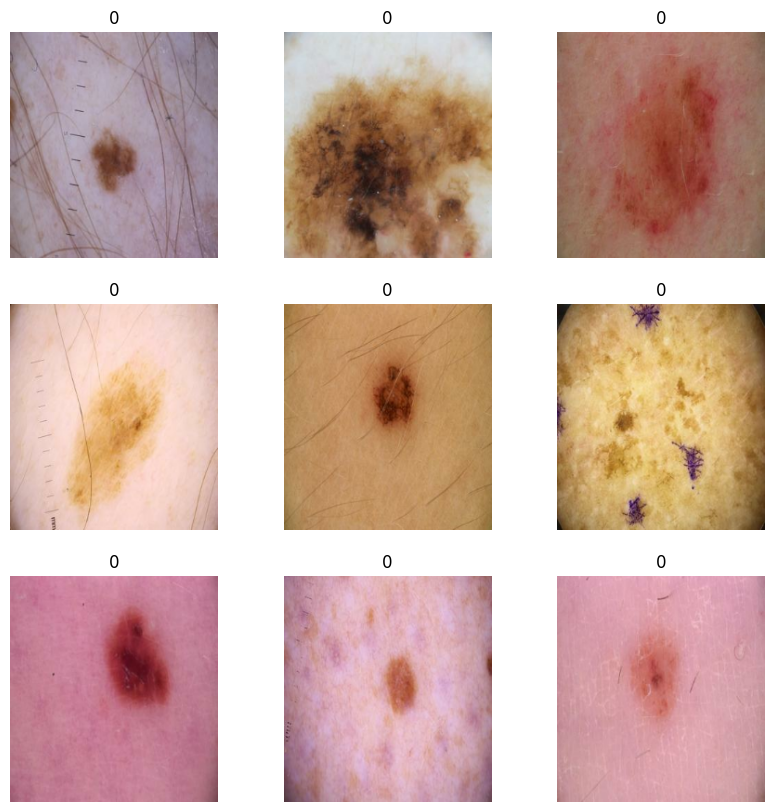

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = labels[i].numpy().argmax()
        plt.title(label_index)  # Display the label index
        plt.axis("off")
plt.show()

In [7]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

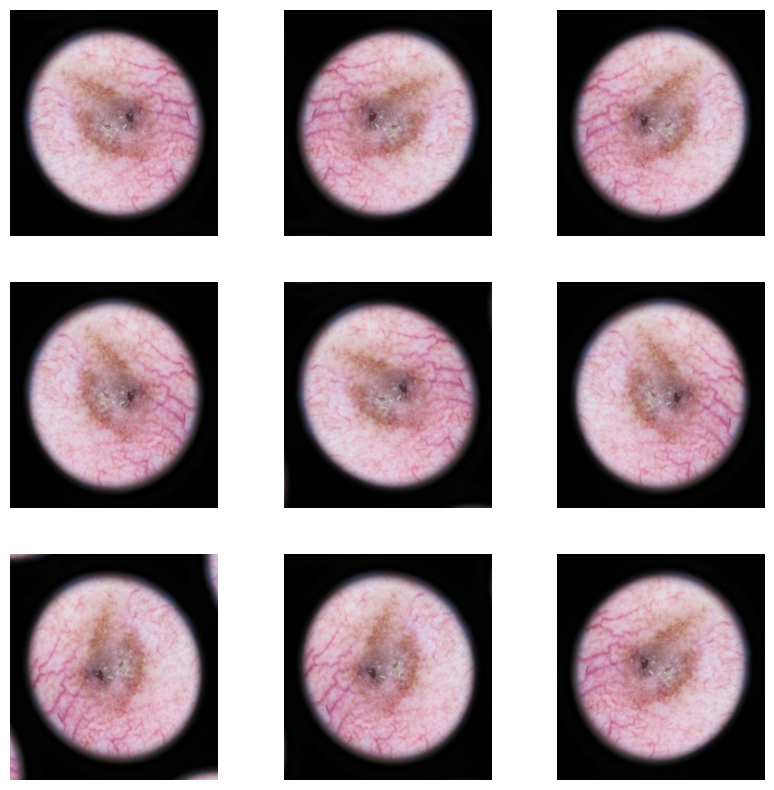

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [8]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(tf.image.resize(img, (224, 224))), label),
    num_parallel_calls=tf_data.AUTOTUNE,)
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [9]:
import keras
from keras import layers

def skin_cancer_cnn(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Normalization
    x = layers.Rescaling(1.0 / 255)(inputs)

    # Block 1
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Block 2
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Block 3
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Block 4
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    if num_classes == 2:
        units = 2
    else:
        units = num_classes

    outputs = layers.Dense(units, activation='softmax')(x)

    return keras.Model(inputs, outputs)

# Define the input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 2  # Assuming binary classification for skin cancer detection

# Create the model
model = skin_cancer_cnn(input_shape=input_shape, num_classes=num_classes)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             

 Total params: 26,084,034 (99.50 MB)

 Trainable params: 26,082,050 (99.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [10]:
from keras import callbacks
epochs = 10

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    # Use categorical crossentropy for multi-class problems
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")],
)
callbacks_list = [
    callbacks.ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min"),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
]
history = model.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729260869.535452     112 service.cc:145] XLA service 0x7e4d68003e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729260869.535509     112 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/301 ━━━━━━━━━━━━━━━━━━━━ 1:34:45 19s/step - accuracy: 0.5625 - loss: 1.1281

I0000 00:00:1729260881.093697     112 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_1', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1729260881.110820     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 36/301 ━━━━━━━━━━━━━━━━━━━━ 3:01 687ms/step - accuracy: 0.7442 - loss: 0.8039

I0000 00:00:1729260905.067705     112 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_2', 68 bytes spill stores, 68 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 48 bytes spill stores, 48 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads



301/301 ━━━━━━━━━━━━━━━━━━━━ 175s 521ms/step - accuracy: 0.8190 - loss: 0.4814 - val_accuracy: 0.5000 - val_loss: 0.7004
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 106s 345ms/step - accuracy: 0.8621 - loss: 0.3252 - val_accuracy: 0.5030 - val_loss: 0.7330
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 105s 341ms/step - accuracy: 0.8738 - loss: 0.3096 - val_accuracy: 0.5040 - val_loss: 0.8618
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 107s 347ms/step - accuracy: 0.8819 - loss: 0.2833 - val_accuracy: 0.7780 - val_loss: 0.4711
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 106s 343ms/step - accuracy: 0.8906 - loss: 0.2677 - val_accuracy: 0.5930 - val_loss: 1.0327
Epoch 6/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 107s 346ms/step - accuracy: 0.8902 - loss: 0.2674 - val_accuracy: 0.6600 - val_loss: 0.6279
Epoch 7/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 106s 345ms/step - accuracy: 0.8874 - loss: 0.2715 - val_accuracy: 0.6300 - val_loss: 0.7144
Epoch 8/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 106s 343ms/step - accuracy: 0.8945 - loss: 0.26

In [11]:
test_data = []
test_labels = []
for _ in range(len(validation_generator)): # Loop through the entire generator
  batch_x, batch_y =next(validation_generator)
  test_data.append(batch_x)
  test_labels.append(batch_y)

# Concatenate all batches into a single array
test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Assuming you have test_data and test_labels ready
loss, accuracy, f1, recall,precision = evaluate_model(model, test_data, test_labels)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Loss: 0.8330
Accuracy: 0.4960
F1 Score: 0.3484
Recall: 0.4960
Precision: 0.4573


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step


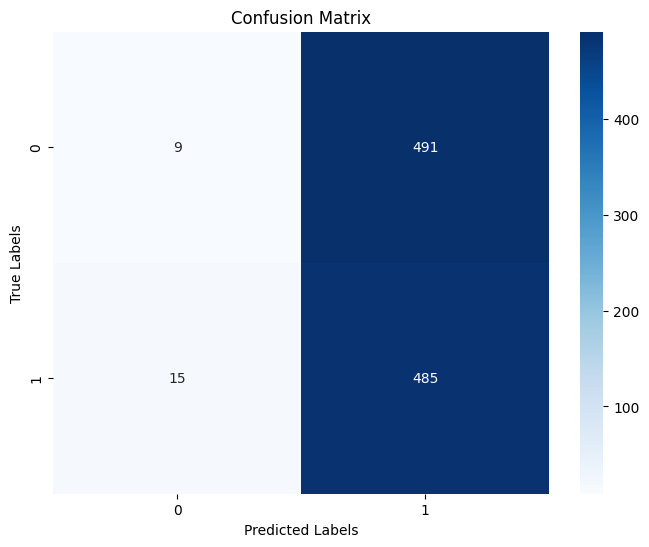

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict the probabilities for the test dataset using the validation_generator
y_pred_prob = model.predict(validation_generator)

# Convert probabilities to class predictions using argmax
y_pred = np.argmax(y_pred_prob, axis=-1)

# Get true labels from the generator
y_true = validation_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the ResNet50 model pre-trained on ImageNet, excluding the top fully connected layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with 1024 units and ReLU activation
x = Dense(1024, activation='relu')(x)

# Add a final fully connected layer with a sigmoid activation for binary classification
predictions = Dense(2, activation='softmax')(x)  # 1 unit for binary classification

# Create the final model
model1 = Model(inputs=base_model.input, outputs=predictions)

# Optionally, freeze the layers of the base model during training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with binary crossentropy for binary classification
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model1.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,687,938 (97.99 MB)

 Trainable params: 2,100,226 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
from keras import callbacks
epochs = 10
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")],
)
callbacks_list = [
    callbacks.ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min"),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
]
history = model1.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:674: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


301/301 ━━━━━━━━━━━━━━━━━━━━ 130s 389ms/step - accuracy: 0.5535 - loss: 0.6852 - val_accuracy: 0.6680 - val_loss: 0.6074
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 107s 346ms/step - accuracy: 0.6785 - loss: 0.6138 - val_accuracy: 0.7430 - val_loss: 0.5589
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 108s 349ms/step - accuracy: 0.6781 - loss: 0.5804 - val_accuracy: 0.7720 - val_loss: 0.5081
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 108s 349ms/step - accuracy: 0.7237 - loss: 0.5565 - val_accuracy: 0.7370 - val_loss: 0.5018
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 107s 348ms/step - accuracy: 0.7445 - loss: 0.5237 - val_accuracy: 0.7400 - val_loss: 0.4916
Epoch 6/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 106s 344ms/step - accuracy: 0.7518 - loss: 0.5160 - val_accuracy: 0.7280 - val_loss: 0.5227
Epoch 7/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 107s 349ms/step - accuracy: 0.7650 - loss: 0.4890 - val_accuracy: 0.8090 - val_loss: 0.4595
Epoch 8/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 110s 357ms/step - accuracy: 0.7668 - loss: 0.47

In [15]:
test_data = []
test_labels = []
for _ in range(len(validation_generator)): # Loop through the entire generator
  batch_x, batch_y =next(validation_generator)
  test_data.append(batch_x)
  test_labels.append(batch_y)

# Concatenate all batches into a single array
test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Assuming you have test_data and test_labels ready
loss, accuracy, f1, recall,precision = evaluate_model(model1, test_data, test_labels)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step
Loss: 0.4458
Accuracy: 0.8110
F1 Score: 0.8094
Recall: 0.8110
Precision: 0.8221


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


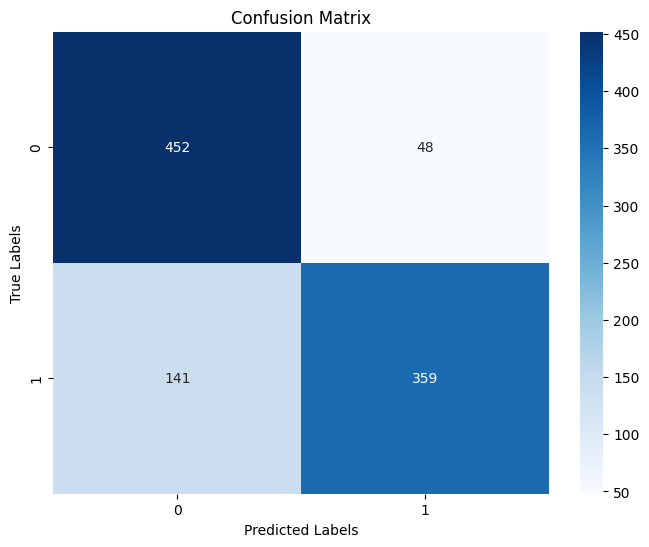

In [16]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the probabilities for the test dataset
y_pred_prob = model1.predict(test_data)

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# If the output is from a softmax layer with multiple classes
if y_pred.shape[-1] > 1:
    y_pred = np.argmax(y_pred, axis=-1)
    test_labels = np.argmax(test_labels, axis=-1)
else:
    y_pred = y_pred.flatten()

# Calculate confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load the VGG-19 model with pre-trained weights on ImageNet
# Set include_top to False to exclude the final fully connected layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers to avoid retraining them
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = Flatten()(base_model.output)  # Flatten the output of the conv layers
x = Dense(256, activation='relu')(x)  # Add a fully connected layer with 256 neurons
x = Dense(128, activation='relu')(x)  # Add another fully connected layer
x = Dense(2, activation='softmax')(x)  # Output layer with 1 neuron and sigmoid activation for binary classification

# Create the new model
model3 = Model(inputs=base_model.input, outputs=x)

# Compile the model
# Use binary_crossentropy for binary classification
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model3.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,89

 Total params: 26,480,322 (101.01 MB)

 Trainable params: 6,455,938 (24.63 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [19]:
from keras import callbacks
epochs = 10
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")],
)
callbacks_list = [
    callbacks.ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min"),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
]
history = model3.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator
)

Epoch 1/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 123s 367ms/step - accuracy: 0.7627 - loss: 0.5927 - val_accuracy: 0.8570 - val_loss: 0.3544
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 106s 344ms/step - accuracy: 0.8737 - loss: 0.3020 - val_accuracy: 0.8910 - val_loss: 0.2522
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 107s 346ms/step - accuracy: 0.8816 - loss: 0.2719 - val_accuracy: 0.8950 - val_loss: 0.2526
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 108s 351ms/step - accuracy: 0.8980 - loss: 0.2439 - val_accuracy: 0.9020 - val_loss: 0.2423
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 106s 344ms/step - accuracy: 0.9006 - loss: 0.2435 - val_accuracy: 0.9040 - val_loss: 0.2217
Epoch 6/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 108s 350ms/step - accuracy: 0.9026 - loss: 0.2295 - val_accuracy: 0.8770 - val_loss: 0.2780
Epoch 7/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 107s 346ms/step - accuracy: 0.9064 - loss: 0.2263 - val_accuracy: 0.9050 - val_loss: 0.2440
Epoch 8/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 107s 348ms/step - accuracy: 0.8945 -

In [20]:
test_data = []
test_labels = []
for _ in range(len(validation_generator)): # Loop through the entire generator
  batch_x, batch_y =next(validation_generator)
  test_data.append(batch_x)
  test_labels.append(batch_y)

# Concatenate all batches into a single array
test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Assuming you have test_data and test_labels ready
loss, accuracy, f1, recall,precision = evaluate_model(model3, test_data, test_labels)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step
Loss: 0.2465
Accuracy: 0.9040
F1 Score: 0.9037
Recall: 0.9040
Precision: 0.9099


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


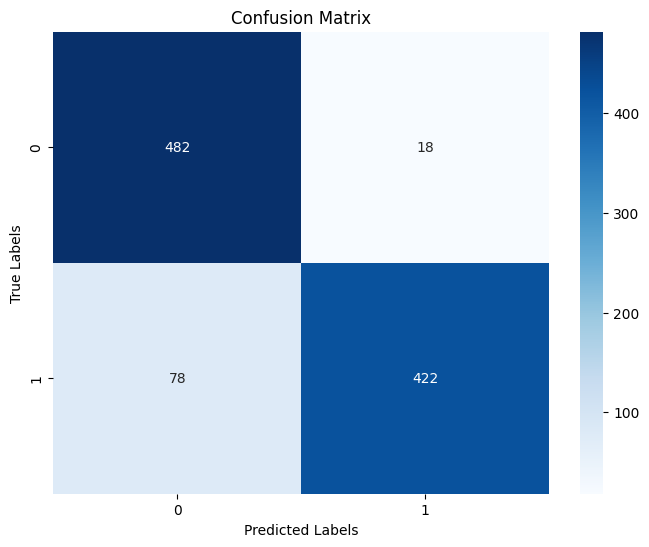

In [21]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the probabilities for the test dataset
y_pred_prob = model3.predict(test_data)

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# If the output is from a softmax layer with multiple classes
if y_pred.shape[-1] > 1:
    y_pred = np.argmax(y_pred, axis=-1)
    test_labels = np.argmax(test_labels, axis=-1)
else:
    y_pred = y_pred.flatten()

# Calculate confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load the VGG-19 model with pre-trained weights on ImageNet
# Set include_top to False to exclude the final fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers to avoid retraining them
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = Flatten()(base_model.output)  # Flatten the output of the conv layers
x = Dense(256, activation='relu')(x)  # Add a fully connected layer with 256 neurons
x = Dense(128, activation='relu')(x)  # Add another fully connected layer
x = Dense(2, activation='softmax')(x)  # Output layer with 1 neuron and sigmoid activation for binary classification

# Create the new model
model4 = Model(inputs=base_model.input, outputs=x)

# Compile the model
# Use binary_crossentropy for binary classification
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model4.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,170,626 (80.76 MB)

 Trainable params: 6,455,938 (24.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
from keras import callbacks
epochs = 10

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
callbacks_list = [
    callbacks.ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min"),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
]
history = model4.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator
)

Epoch 1/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 115s 367ms/step - accuracy: 0.7858 - loss: 0.5099 - val_accuracy: 0.8980 - val_loss: 0.2412
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 106s 345ms/step - accuracy: 0.8852 - loss: 0.2759 - val_accuracy: 0.9080 - val_loss: 0.2304
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 105s 341ms/step - accuracy: 0.8894 - loss: 0.2591 - val_accuracy: 0.9000 - val_loss: 0.2300
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 106s 343ms/step - accuracy: 0.8995 - loss: 0.2445 - val_accuracy: 0.9070 - val_loss: 0.2309
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 106s 342ms/step - accuracy: 0.9179 - loss: 0.2018 - val_accuracy: 0.9220 - val_loss: 0.2197
Epoch 6/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 108s 350ms/step - accuracy: 0.9182 - loss: 0.2011 - val_accuracy: 0.9090 - val_loss: 0.2041
Epoch 7/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 107s 349ms/step - accuracy: 0.9083 - loss: 0.2179 - val_accuracy: 0.9140 - val_loss: 0.2126
Epoch 8/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 108s 349ms/step - accuracy: 0.9169 -

In [25]:

# Use a loop to get all the batches of data
test_data = []
test_labels = []
for _ in range(len(validation_generator)): # Loop through the entire generator
  batch_x, batch_y =next(validation_generator)
  test_data.append(batch_x)
  test_labels.append(batch_y)

# Concatenate all batches into a single array
test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Assuming you have test_data and test_labels ready
loss, accuracy, f1, recall,precision = evaluate_model(model4, test_data, test_labels)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step
Loss: 0.2098
Accuracy: 0.9080
F1 Score: 0.9080
Recall: 0.9080
Precision: 0.9081


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


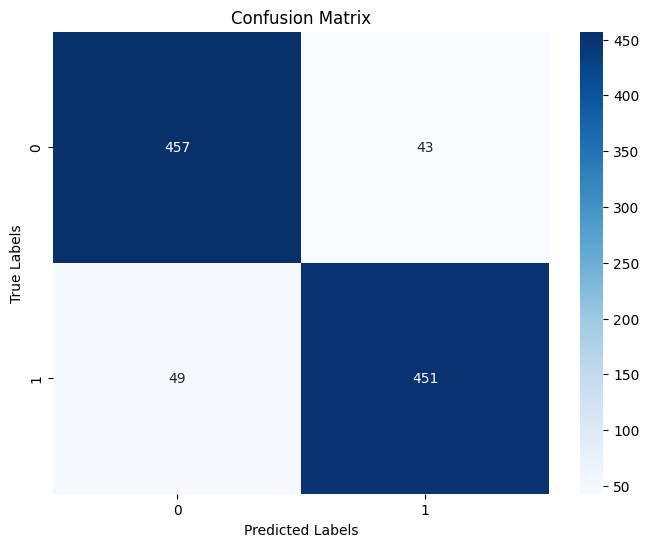

In [26]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the probabilities for the test dataset
y_pred_prob = model4.predict(test_data)

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# If the output is from a softmax layer with multiple classes
if y_pred.shape[-1] > 1:
    y_pred = np.argmax(y_pred, axis=-1)
    test_labels = np.argmax(test_labels, axis=-1)
else:
    y_pred = y_pred.flatten()

# Calculate confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [27]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Create a Sequential model
model5 = Sequential()

# Input layer (adjust input_shape as needed)
model5.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model5.add(MaxPooling2D((2, 2)))

# Residual blocks (adjust the number of blocks and filters as desired)
model5.add(Conv2D(128, (3, 3), activation='relu'))
model5.add(Conv2D(128, (3, 3), activation='relu'))
model5.add(MaxPooling2D((2, 2)))

model5.add(Conv2D(256, (3, 3), activation='relu'))
model5.add(Conv2D(256, (3, 3), activation='relu'))
model5.add(MaxPooling2D((2, 2)))

model5.add(Conv2D(512, (3, 3), activation='relu'))
model5.add(Conv2D(512, (3, 3), activation='relu'))
model5.add(MaxPooling2D((2, 2)))

# Flatten the feature maps
model5.add(Flatten())

# Fully connected layers (adjust the number of neurons and layers as needed)
model5.add(Dense(256, activation='relu'))
model5.add(Dense(128, activation='relu'))
model5.add(Dense(2, activation='softmax'))

# Compile the model
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             

 Total params: 78,248,136 (298.49 MB)

 Trainable params: 26,082,050 (99.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 52,164,102 (198.99 MB)

In [29]:
from keras import callbacks
epochs = 10

model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

callbacks_list = [
    callbacks.ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min"),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
]
history = model5.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator
)

Epoch 1/10
 30/301 ━━━━━━━━━━━━━━━━━━━━ 2:13 492ms/step - accuracy: 0.5235 - loss: 0.7006

I0000 00:00:1729266295.130899     110 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_11', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_5', 128 bytes spill stores, 128 bytes spill loads



301/301 ━━━━━━━━━━━━━━━━━━━━ 124s 391ms/step - accuracy: 0.5667 - loss: 0.6892 - val_accuracy: 0.7740 - val_loss: 0.4709
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 107s 347ms/step - accuracy: 0.7998 - loss: 0.4496 - val_accuracy: 0.8450 - val_loss: 0.3505
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 142s 347ms/step - accuracy: 0.8427 - loss: 0.3621 - val_accuracy: 0.8690 - val_loss: 0.3259
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 107s 346ms/step - accuracy: 0.8407 - loss: 0.3722 - val_accuracy: 0.8620 - val_loss: 0.3697
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 109s 352ms/step - accuracy: 0.8641 - loss: 0.3303 - val_accuracy: 0.8660 - val_loss: 0.3167
Epoch 6/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 107s 348ms/step - accuracy: 0.8522 - loss: 0.3382 - val_accuracy: 0.8710 - val_loss: 0.3158
Epoch 7/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 107s 346ms/step - accuracy: 0.8670 - loss: 0.3174 - val_accuracy: 0.8670 - val_loss: 0.3047
Epoch 8/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 107s 347ms/step - accuracy: 0.8665 - loss: 0.31

In [30]:
test_data = []
test_labels = []
for _ in range(len(validation_generator)): # Loop through the entire generator
  batch_x, batch_y =next(validation_generator)
  test_data.append(batch_x)
  test_labels.append(batch_y)

# Concatenate all batches into a single array
test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Assuming you have test_data and test_labels ready
loss, accuracy, f1, recall,precision = evaluate_model(model5, test_data, test_labels)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
Loss: 0.2597
Accuracy: 0.8990
F1 Score: 0.8989
Recall: 0.8990
Precision: 0.9010


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


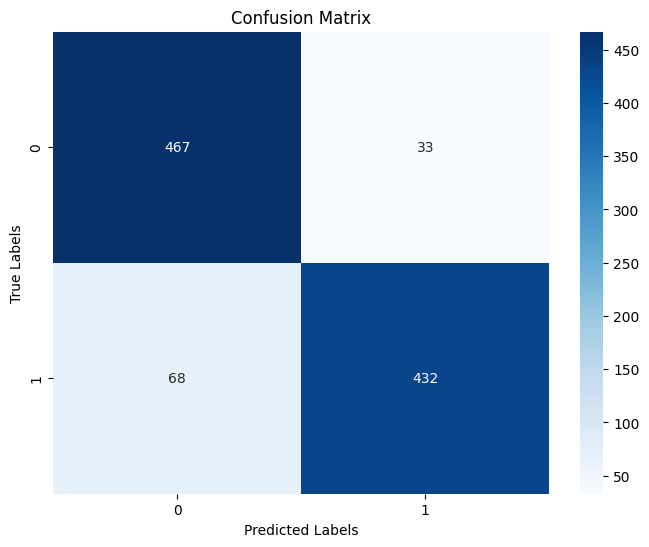

In [31]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the probabilities for the test dataset
y_pred_prob = model5.predict(test_data)

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# If the output is from a softmax layer with multiple classes
if y_pred.shape[-1] > 1:
    y_pred = np.argmax(y_pred, axis=-1)
    test_labels = np.argmax(test_labels, axis=-1)
else:
    y_pred = y_pred.flatten()

# Calculate confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


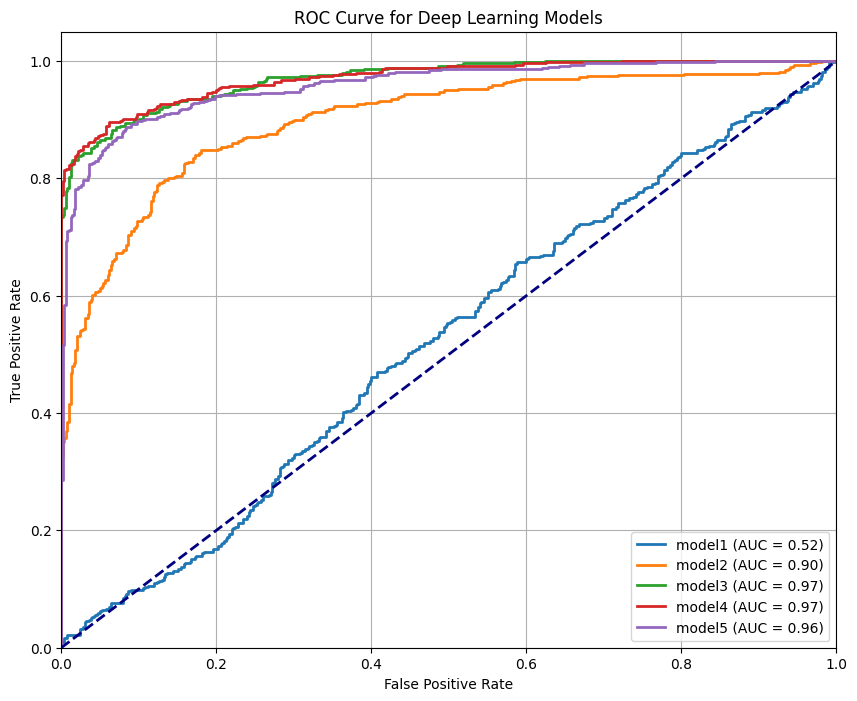

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have trained models and test data
# y_true: True binary labels for the test set
# model_list: List of DL models (e.g., Keras models)
X_test = test_data
y_true =  test_labels # True binary labels for the test set
model_list = [model, model1, model3, model4, model5]  # DL models
model_names = ['model1', 'model2', 'model3', 'model4', 'model5']

plt.figure(figsize=(10, 8))

for i, model in enumerate(model_list):
    # Get predicted probabilities for the positive class (e.g., using model.predict)
    y_pred = model.predict(X_test)  # X_test is your test data
    # If predict returns probabilities for both classes, use [:, 1] for the positive class
    if y_pred.shape[1] > 1:
        y_pred = y_pred[:, 1]
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for each model
    plt.plot(fpr, tpr, lw=2, label=f'{model_names[i]} (AUC = {roc_auc:.2f})')

# Plot diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Deep Learning Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, recall_score, accuracy_score,precision_score
from keras.metrics import MeanSquaredError
from keras.losses import CategoricalCrossentropy # Changed to CategoricalCrossentropy
from keras.utils import to_categorical


def evaluate_model(model, test_data, test_labels):
    # Predict the probabilities for the test dataset
    y_pred_prob = model.predict(test_data)

    # Convert probabilities to class predictions
    y_pred = np.argmax(y_pred_prob, axis=-1)

    # One-hot encode test_labels
    #test_labels = to_categorical(test_labels, num_classes=9) # This line is not needed as test_labels are already one-hot encoded.

    # Calculate accuracy
    accuracy = accuracy_score(np.argmax(test_labels, axis=-1), y_pred)

    # Calculate F1 score
    # Use 'weighted' average for multiclass data
    f1 = f1_score(np.argmax(test_labels, axis=-1), y_pred, average='weighted')
    precision = precision_score(np.argmax(test_labels, axis=-1), y_pred, average='weighted')

    # Calculate recall
    # Use 'weighted' average for multiclass data
    recall = recall_score(np.argmax(test_labels, axis=-1), y_pred, average='weighted')

    # Calculate categorical crossentropy loss
    loss_fn = CategoricalCrossentropy() # Changed to CategoricalCrossentropy
    loss = loss_fn(test_labels, y_pred_prob).numpy()

    return loss, accuracy, f1, recall,precision

In [ ]:
import keras
from keras import layers

def skin_cancer_cnn(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Normalization
    x = layers.Rescaling(1.0 / 255)(inputs)

    # Block 1
    x = layers.Conv2D(32, 4, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("sigmoid")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Block 2
    x = layers.Conv2D(64, 4, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("sigmoid")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Block 3
    x = layers.Conv2D(128, 4, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("sigmoid")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Block 4
    x = layers.Conv2D(256, 4, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("sigmoid")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("sigmoid")(x)
    x = layers.Dropout(0.5)(x)

    if num_classes == 2:
        units = 2
    else:
        units = num_classes

    outputs = layers.Dense(units, activation='softmax')(x)

    return keras.Model(inputs, outputs)

# Define the input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 2  # Assuming binary classification for skin cancer detection

# Create the model
model1 = skin_cancer_cnn(input_shape=input_shape, num_classes=num_classes)
model1.summary()


In [ ]:
from keras import callbacks
epochs = 10

# Use categorical_crossentropy for multi-class problems

model1.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=4e-2),
    # Use categorical crossentropy for multi-class problems
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")],
)
callbacks_list = [
    callbacks.ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min"),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
]
history = model1.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator
)

In [ ]:
test_data = []
test_labels = []
for _ in range(len(validation_generator)): # Loop through the entire generator
  batch_x, batch_y =next(validation_generator)
  test_data.append(batch_x)
  test_labels.append(batch_y)

# Concatenate all batches into a single array
test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Assuming you have test_data and test_labels ready
loss, accuracy, f1, recall,precision = evaluate_model(model1, test_data, test_labels)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the ResNet50 model pre-trained on ImageNet, excluding the top fully connected layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with 1024 units and ReLU activation
x = Dense(256, activation='sigmoid')(x)

# Add a final fully connected layer with a sigmoid activation for binary classification
predictions = Dense(2, activation='softmax')(x)  # 1 unit for binary classification

# Create the final model
model2 = Model(inputs=base_model.input, outputs=predictions)

# Optionally, freeze the layers of the base model during training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with binary crossentropy for binary classification
model2.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model2.summary()

In [ ]:
from keras import callbacks
epochs = 15

model2.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=4e-2),
    # Use categorical crossentropy for multi-class problems
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")],
)
callbacks_list = [
    callbacks.ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min"),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
]
history = model2.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator
)

In [ ]:
test_data = []
test_labels = []
for _ in range(len(validation_generator)): # Loop through the entire generator
  batch_x, batch_y =next(validation_generator)
  test_data.append(batch_x)
  test_labels.append(batch_y)

# Concatenate all batches into a single array
test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Assuming you have test_data and test_labels ready
loss, accuracy, f1, recall,precision = evaluate_model(model2, test_data, test_labels)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load the VGG-19 model with pre-trained weights on ImageNet
# Set include_top to False to exclude the final fully connected layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers to avoid retraining them
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = Flatten()(base_model.output)  # Flatten the output of the conv layers
x = Dense(1028, activation='sigmoid')(x)  # Add a fully connected layer with 256 neurons
x = Dense(128, activation='sigmoid')(x)  # Add another fully connected layer
x = Dense(2, activation='softmax')(x)  # Output layer with 1 neuron and sigmoid activation for binary classification

# Create the new model
model3 = Model(inputs=base_model.input, outputs=x)

# Print a summary of the model architecture
model3.summary()

In [ ]:
from keras import callbacks
epochs = 15

model3.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=4e-2),
    # Use categorical crossentropy for multi-class problems
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")],
)
callbacks_list = [
    callbacks.ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min"),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
]
history = model3.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator
)

In [ ]:
test_data = []
test_labels = []
for _ in range(len(validation_generator)): # Loop through the entire generator
  batch_x, batch_y =next(validation_generator)
  test_data.append(batch_x)
  test_labels.append(batch_y)

# Concatenate all batches into a single array
test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Assuming you have test_data and test_labels ready
loss, accuracy, f1, recall,precision = evaluate_model(model3, test_data, test_labels)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load the VGG-19 model with pre-trained weights on ImageNet
# Set include_top to False to exclude the final fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers to avoid retraining them
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = Flatten()(base_model.output)  # Flatten the output of the conv layers
x = Dense(1028, activation='sigmoid')(x)  # Add a fully connected layer with 256 neurons
x = Dense(128, activation='sigmoid')(x)  # Add another fully connected layer
x = Dense(2, activation='softmax')(x)  # Output layer with 1 neuron and sigmoid activation for binary classification

# Create the new model
model4 = Model(inputs=base_model.input, outputs=x)

# Print a summary of the model architecture
model4.summary()

In [ ]:
from keras import callbacks
epochs = 15

model4.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=4e-2),
    # Use categorical crossentropy for multi-class problems
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")],
)
callbacks_list = [
    callbacks.ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min"),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
]
history = model4.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator
)

In [ ]:
test_data = []
test_labels = []
for _ in range(len(validation_generator)): # Loop through the entire generator
  batch_x, batch_y =next(validation_generator)
  test_data.append(batch_x)
  test_labels.append(batch_y)

# Concatenate all batches into a single array
test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Assuming you have test_data and test_labels ready
loss, accuracy, f1, recall,precision = evaluate_model(model4, test_data, test_labels)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Create a Sequential model
model5 = Sequential()

# Input layer (adjust input_shape as needed)
model5.add(Conv2D(64, (4, 4), activation='sigmoid', input_shape=(224, 224, 3)))
model5.add(MaxPooling2D((3, 3)))

# Residual blocks (adjust the number of blocks and filters as desired)
model5.add(Conv2D(128, (4, 4), activation='sigmoid'))
model5.add(Conv2D(128, (4, 4), activation='sigmoid')
model5.add(MaxPooling2D((3, 3)))

model5.add(Conv2D(256, (4, 4), activation='sigmoid'))
model5.add(Conv2D(256, (4, 4), activation='sigmoid')
model5.add(MaxPooling2D((3, 3)))

model5.add(Conv2D(512, (4, 4), activation='sigmoid'))
model5.add(Conv2D(512, (4, 4), activation='sigmoid'))
model5.add(MaxPooling2D((3, 3)))

# Flatten the feature maps
model5.add(Flatten())

# Fully connected layers (adjust the number of neurons and layers as needed)
model5.add(Dense(256, activation='sigmoid'))
model5.add(Dense(128, activation='sigmoid'))
model5.add(Dense(2, activation='softmax'))

model.summary()

In [ ]:
from keras import callbacks
epochs = 15

model5.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=4e-2),
    # Use categorical crossentropy for multi-class problems
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")],
)
callbacks_list = [
    callbacks.ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min"),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
]
history = model5.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator
)

In [ ]:
test_data = []
test_labels = []
for _ in range(len(validation_generator)): # Loop through the entire generator
  batch_x, batch_y =next(validation_generator)
  test_data.append(batch_x)
  test_labels.append(batch_y)

# Concatenate all batches into a single array
test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Assuming you have test_data and test_labels ready
loss, accuracy, f1, recall,precision = evaluate_model(model5, test_data, test_labels)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')